<a href="https://colab.research.google.com/github/SvgPrizrak/ML_Sber_Homework/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22final_project%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальный проект

# 0. Выбор набора данных

Выберите интересующий вас набор данных - свой, из перечисленных ниже или какой-либо другой:

- [Spotify Tracks DB](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db) - характеристики треков в spotify
- [VKontakte Dataset of Users' Textual Data](https://www.kaggle.com/oldaandozerskaya/vkontakte-dataset-of-users-textual-data) - основная информация 10к профилей ВК
- [Data Science for COVID-19](https://www.kaggle.com/kimjihoo/coronavirusdataset) - информация о распространении коронавируса в Южной Корее в 2020 году
- [Dota 2 - Pro Players Matches Results 2019 ~ 2021](https://www.kaggle.com/devinanzelmo/dota-2-matches?select=player_ratings.csv) - информация матчей игроков DoTA 2
- [GPS Data of Seabirds](https://www.kaggle.com/saurabhshahane/predicting-animal-behavior-using-gps) - данные о миграции птиц
- [FAANG Historical Stock Price Data](https://www.kaggle.com/specter7/amazon-amzn-historical-stock-price-data) -  данные о биржевых котировках компаний FAANG c 2016 по 2021 год
- [NBA 2k20 player dataset](https://www.kaggle.com/isaienkov/nba2k20-player-dataset) - информация об игроках NBA
- [Anime dataset](https://www.kaggle.com/thunderz/anime-dataset?select=user_data.csv) - данные о просмотре аниме пользователями с сайта myAnimeList

>**Примечание**
>
>Если данные не влезают в память, можно воспользоваться библиотекой [Dask](https://dask.org/) - аналогом pandas для обработки вне RAM.

In [ ]:
# Здесь вы загружаете датасет в colab (требуется kaggle.json)
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# выберем набор данных с характеристиками треков в spotify
!kaggle datasets download zaheenhamidani/ultimate-spotify-tracks-db

Saving kaggle.json to kaggle.json
ultimate-spotify-tracks-db.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# получение данных из архива
from zipfile import ZipFile

# имя архива
file = "ultimate-spotify-tracks-db.zip"

# чтение файлов
with ZipFile(file, 'r') as zip:

    # чтение файлов
    zip.printdir()

    # извлечение файлов
    print('extraction...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
SpotifyFeatures.csv                            2019-10-19 19:54:44     33709086
extraction...
Done!


In [ ]:
# установим catboost для обучения
!pip install catboost

In [ ]:
# все требуемые библиотеки для построения модели
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# изменение данных
from sklearn.preprocessing import StandardScaler

# понижение размерности
from sklearn.decomposition import PCA

# формула для определения средних межкластерных расстояний
from sklearn.metrics import pairwise_distances

# для обучения модели
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# модели машинного обучения (классификация и кластеризация)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

# метрики
from sklearn.metrics import classification_report

# рандомизация
import random

In [ ]:
# обработка ошибок
import warnings
warnings.filterwarnings('ignore')

# 1. Предобработка (5 баллов)


In [ ]:
# чтение данных, полученных из Kaggle
input_data = pd.read_csv('SpotifyFeatures.csv')
input_data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


Выполните предобработку данных:

1. (1 балл) Недостающие данные в датасете - найдите и обработайте их, удалить/заменить/etc, обоснуйте своё решение:

In [ ]:
# Здесь вы обрабатываете пропуски в данных - пустые значения отсутствуют - что указано было в самой информации по датасету, нет смысла делать заполнение данных
input_data.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [ ]:
# для идентификации песен существует поле track_id и вот тут появляется первая проблема - у одного трека может быть несколько жанров
input_data['track_id'].value_counts()

# track_id впоследствии будет удален, но лучше его оставить до этапа предобработки таблицы (после построения графиков)
input_data[input_data['track_id'] == '3R73Y7X53MIQZWnKloWq5i']

# проверим что track_id не пересекаются, т.е. одна песня - один track_id
input_data.groupby(['artist_name', 'track_name'])['track_id'].nunique().sort_values(ascending=False).head(20)

artist_name              track_name                             
B.B. King                The Thrill Is Gone                         3
Matthew West             Broken Things                              3
Tora                     Too Much                                   2
Mike Shinoda             Promises I Can't Keep                      2
                         Crossing A Line                            2
                         Ghosts                                     2
The Edgar Winter Group   Frankenstein                               2
Bleachers                Wild Heart                                 2
Gabriel Garzón-Montano   6 8                                        2
Five Finger Death Punch  No One Gets Left Behind                    2
Mike Shinoda             Running From My Shadow (feat. grandson)    2
Washed Out               New Theory                                 2
Nirvana                  Rape Me                                    2
Ella Fitzgerald          

In [ ]:
# надо понимать, что track_id для одной и той песни может быть разный (и как следствие характеристики песни могут меняться!) - еще один повод пока не трогать track_id
input_data[input_data['track_name'] == 'The Thrill Is Gone']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
45861,Blues,B.B. King,The Thrill Is Gone,3cg0dJfrQB66Qf2YthPb6G,59,0.0934,0.692,301133,0.493,0.00166,A,0.1280,-9.662,Minor,0.0325,86.644,4/4,0.280
48633,Blues,Jerry Garcia,The Thrill Is Gone,0xux34xBBIw9gCWXSLNjbw,32,0.8110,0.794,284227,0.273,0.11300,A,0.0811,-17.428,Minor,0.0541,104.664,4/4,0.748
146789,Jazz,B.B. King,The Thrill Is Gone,4NQfrmGs9iQXVQI9IpRhjM,54,0.3440,0.547,324733,0.460,0.44200,B,0.0983,-8.759,Minor,0.0256,90.768,4/4,0.543
153960,Rock,B.B. King,The Thrill Is Gone,6gRGLfswEsfpy1UxHEyP6X,63,0.0854,0.693,301133,0.489,0.00234,A,0.1310,-9.709,Minor,0.0316,87.085,4/4,0.262
193613,Soul,B.B. King,The Thrill Is Gone,6gRGLfswEsfpy1UxHEyP6X,63,0.0854,0.693,301133,0.489,0.00234,A,0.1310,-9.709,Minor,0.0316,87.085,4/4,0.262


In [ ]:
# проверим есть ли опечатки в названии жанрах песен - да(в Children's Music и Children’s Music) - надо заменить апостроф на запятую
print(sorted(input_data['genre'].unique()))

# собственно сама замена значений
input_data.loc[input_data['genre'] == 'Children’s Music', 'genre'] = "Children's Music"

['A Capella', 'Alternative', 'Anime', 'Blues', "Children's Music", 'Children’s Music', 'Classical', 'Comedy', 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World']


In [ ]:
# проверим опечатки в time_signature - присутствует тактовый размер 0/4, что кажется достаточно странным - эти данные надо удалить, они сильно не повлияют на результат
input_data['time_signature'].value_counts()

# удаление некорректного time_signature
input_data = input_data[input_data['time_signature'] != '0/4']
input_data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


In [ ]:
# аналогично поступим с key и mode - тут все в порядке, некорректных значений нет
print(input_data['key'].value_counts())
print()
print(input_data['mode'].value_counts())

C     27579
G     26390
D     24076
C#    23200
A     22671
F     20278
B     17661
E     17390
A#    15526
F#    15222
G#    15158
D#     7566
Name: key, dtype: int64

Major    151737
Minor     80980
Name: mode, dtype: int64


**Ваше обоснование:** удаление или замена значений связана в первую очередь с некорректными значениями (как в `time_signature`) или же повтором данных (как в `genre`). Остальные колонки будут предобработаны ниже, поскольку перед этапом построения графиков названия колонок и значения признаков лучше оставить как есть с точки зрения интерпретации (+ некоторые модели классификации умеют работать только с числами, а у нас есть категориальные признаки, которые хотелось бы отобразить графически).


2. (1 балл) Выполните визуализацию данных, использовав как минимум по 1 графику каждого типа (plot, hist, piechart, boxplot, scatter). Для каждого построенного графика объясните почему отображённые данные лучше всего представимы именно этим типом графика:

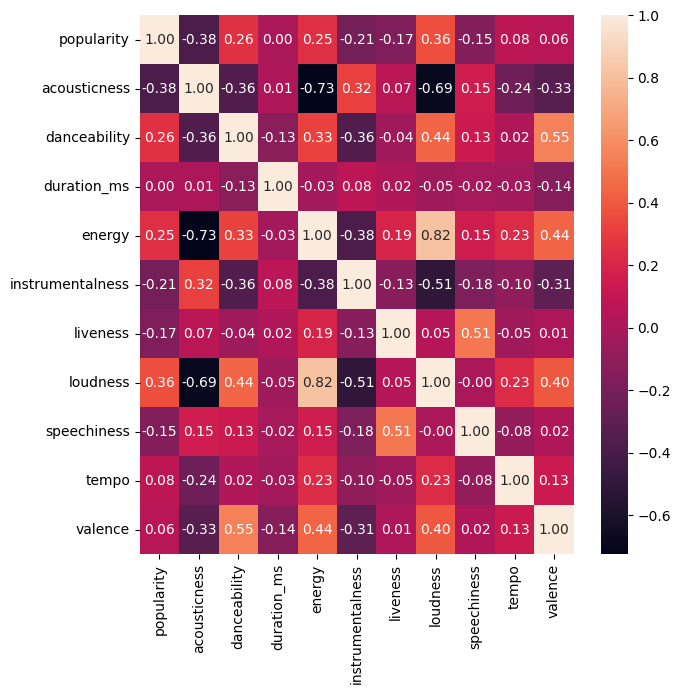

In [ ]:
# прежде чем строить графики надо оценить корреляцию признаков - может вообще стоить что-то удалить
# все признаки оставляем - коэффициент корреляции не настолько высок, чтобы привести к мультиколлинеарности
plt.figure(figsize=(7, 7))
sns.heatmap(input_data.corr(numeric_only=True), annot=True, fmt='.2f')
plt.show()

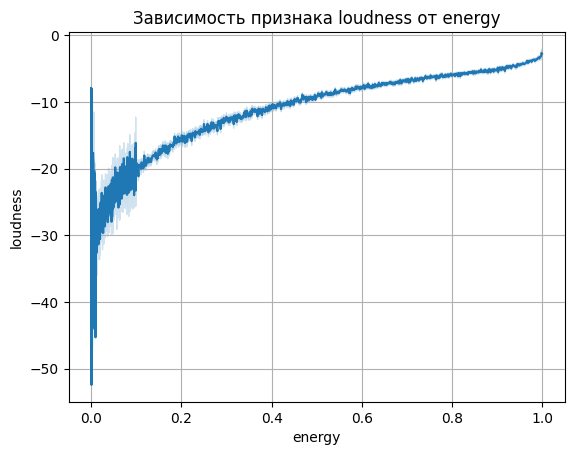

In [ ]:
# Здесь вы строите plot - c линейным графиком не все так просто - много точек, но можно по форме понять распределение + он достаточно долго строится с таким количеством точек
sns.lineplot(data=input_data, x='energy', y='loudness')
plt.title('Зависимость признака loudness от energy')
plt.grid()
plt.show()

**Ваше обоснование:** lineplot обычно строится при определении временной зависимости (как пример - численная величина от года) или же при проверке корреляции двух численных признаков (как в данном случае). График был построен для проверки наличия тренда двух признаков с самой высоким коэффициентом линейной корреляции (0.82) - `loudness` и `energy`. Аналогичные графики можно построить и для других признаков, но конкретно на данном датасете они будут не слишком информативны (есть scatterplot и hexbin, которые быстрее построить). Можно понять, что чем громче песня, тем она более "энергична" (параметр `loudness` судя по всему считается в логарифмических единицах).





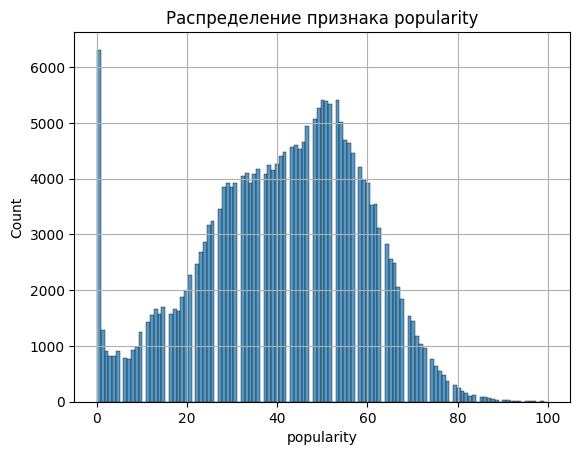

In [ ]:
# Здесь вы строите hist
sns.histplot(data=input_data, x='popularity')
plt.title('Распределение признака popularity')
plt.grid()
plt.show()

**Ваше обоснование:** если мы планируем предсказывать популярность трека, то при преобразовании величины следует попробовать подобрать метки таким образом, чтобы избежать сильного дисбаланса классов в ту или иную сторону. Для этого обязательно надо знать ее распределение (гистограмму). Можно предположить, что трек взлетает в ТОП, потом продолжает некоторое время "жить" в первой сотне.



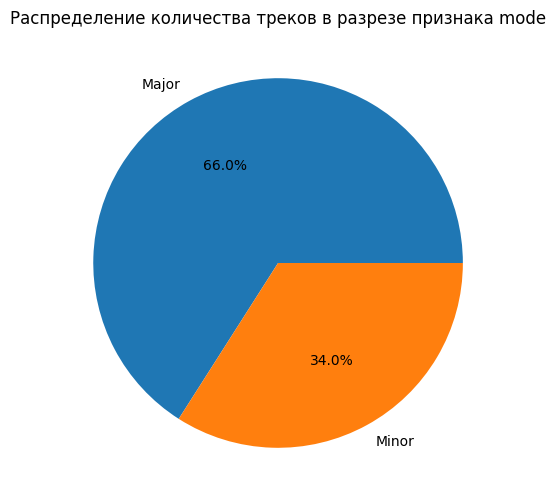

In [ ]:
# Здесь вы строите piechart
for_pieplot_df = input_data.groupby(['mode'], as_index=False)['track_id'].nunique()
plt.figure(figsize=(6, 6))
plt.title('Распределение количества треков в разрезе признака mode')
plt.pie(for_pieplot_df['track_id'], labels=for_pieplot_df['mode'], autopct='%1.1f%%')
plt.show()

**Ваше обоснование:** piechart/pieplot при аналитике данных используется крайне редко - зачастую малоинформативен и может искажать представление при наличии большого количества категориальных признаков (чаще всего показывает именно распределение категориальных признаков - чаще всего количество элементов с данным признаком). В случае нашего датафрейма проще всего использовать признак `mode` - мало признаков, можно посмотреть, сколько у нас "веселых" и "грустных" песен. С остальными признаками pieplot построить сложно (проще смотреть через `value_counts`).



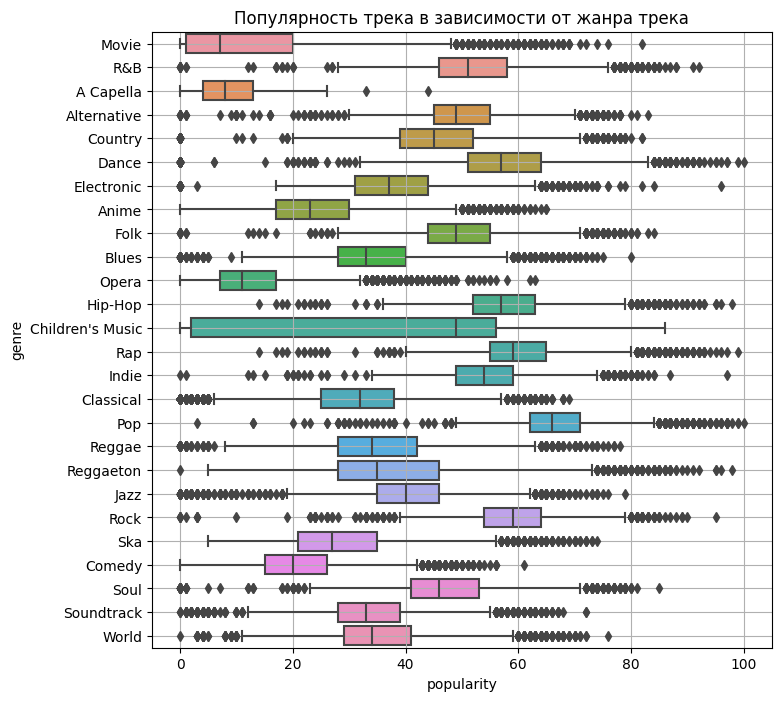

In [ ]:
# Здесь вы строите boxplot
plt.figure(figsize=(8, 8))
plt.title('Популярность трека в зависимости от жанра трека')
sns.boxplot(data=input_data, x='popularity', y='genre')
plt.grid()
plt.show()

**Ваше обоснование:** если мы хотим посмотреть зависимость популярности музыки от жанра (категориального признака от численного) с учетом выбросов, то проще всего посмотреть на ящик с усами. Видно, что популярностью пользуются треки из кино, музыка для детей и песни "А капелла". Близко к ТОП-10 стоит также оперные песни. В целом - жанр музыки влияет на ее популярность (связано с рекламой, известностью самих исполнителей, наградами и премиями и т.д.)



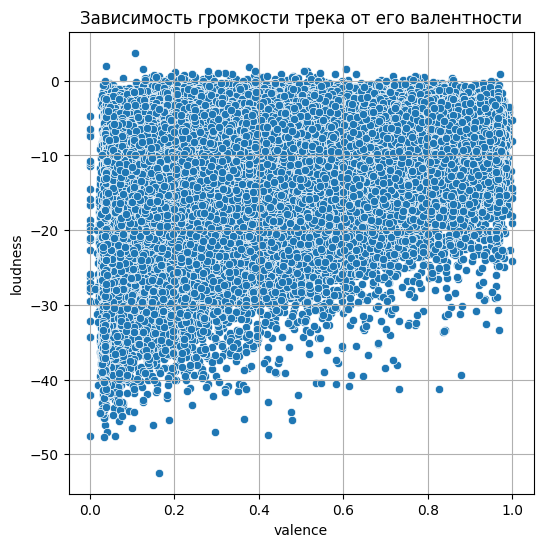

In [ ]:
# Здесь вы строите scatter
plt.figure(figsize=(6, 6))
plt.title('Зависимость громкости трека от его валентности')
sns.scatterplot(data=input_data, x='valence', y='loudness')
plt.grid()
plt.show()

**Ваше обоснование:** при просмотре графика линейной корреляции Пирсона хотелось бы проверить наличие зависимости валентности трека от его громкости (численного признака от численного). Предположение: чем более валентна песня, тем она более громкая. Количество точек и коэффициент линейной корреляции позволяет видеть тренд ("более валентная" <-> "более тихая"), однако однозначно об этом утверждать нельзя.



3. (1 балл) Создайте новую колонку (новый признак). Новая колонка должна обладать смысловой нагрузкой и является некоторой характеристикой набора данных.


>**Пример**
>
>Для набора данных о прямоугольниках с двумя колонками `width` и `height` будет корректно придумать колонку `square`, равную `width * height` или `perimeter`.
>
>Некорректно будет придумать колонку `width2`, равную `width * 2`, потому что эта информация не будет нести полезную информацию о фигурах

In [ ]:
# Здесь вы создаете новую колонку

# в качестве нового признака можно выбрать количество исполнителей (группа будет считаться за одного исполнителя)
def get_artists_count(text: str, symbols_list : list = ['+', 'Feat. ', 'feat. ', '&']):

    '''
    Функция возвращает количество исполнителей трека

    Args:
    * text - входной текст;
    * symbols_list

    Returns:
    * Количество исполнителей в треке -> int
    '''

    # изначальное количество исполнителей
    atrists_count = 1

    for i_elem in symbols_list:
        atrists_count += text.count(i_elem)

    return atrists_count


# получем количество исполнителей
input_data['artists_count'] = input_data['artist_name'].apply(lambda x: get_artists_count(x))

# получем длину трека в символах
input_data['track_name_length'] = input_data['track_name'].apply(lambda x: len(x))
input_data

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists_count,track_name_length
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,1,27
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,2,32
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,1,30
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,1,30
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962,1,12
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969,2,12
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813,1,30
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489,1,13


**Ваше обоснование:** в качестве признаков можно выбрать длину трека и количества исполнителей трека. В первом случае популярность трека может зависеть от длины, поскольку трек проще будет найти в поисковой строке платформы. Количество исполнителей может иметь синергический эффект (несколько известных исполнителей в одном треке, что также может иметь влияние на популярность).



4. (2 балла) Выдвиньте 2 предположения (гипотезы) о данных и подкрепляете их с помощью информации, полученной вами при предобработке данных (для этого возможно придется построить еще пару графиков).

>**Пример**
>
>Для датасета codeforces достаточно интересной гипотезой может быть `"простые задачи (рейтинг меньше 1500) почти всегда решаются больше 5000 раз"`.

**Гипотеза 1:** Мажорные песни более популярные в Spotify нежели минорные как в целом, так и в процентном соотношении.



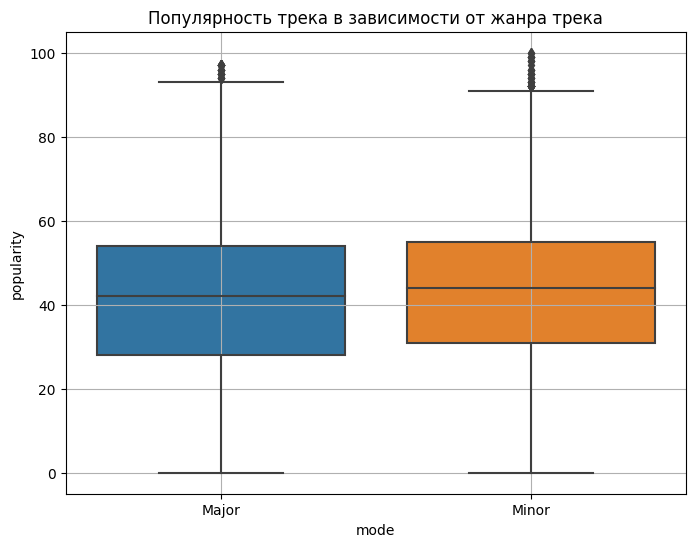

In [ ]:
# (Опционально) Здесь вы "подтверждаете" свою гипотезу - по boxplot видно, что выбросов больше среди минорных песен + медиана все-таки чуть ниже у мажорных песен
plt.figure(figsize=(8, 6))
plt.title('Популярность трека в зависимости от жанра трека')
sns.boxplot(data=input_data, x='mode', y='popularity')
plt.grid()
plt.show()

In [ ]:
# в ТОП-30 попадают около 38% мажорных песен из всех мажорных
input_data[(input_data['mode'] == 'Major') & (input_data['popularity'] <= 30)]['track_id'].nunique() / input_data[(input_data['mode'] == 'Major')]['track_id'].nunique()

0.3798257499099594

In [ ]:
# в ТОП-30 попадают около 31,5% минорных песен из всех минорных
input_data[(input_data['mode'] == 'Minor') & (input_data['popularity'] <= 30)]['track_id'].nunique() / input_data[(input_data['mode'] == 'Minor')]['track_id'].nunique()

0.3154237457193204

В целом, если мы хотим попасть в ТОП песен Spotify, лучше все-таки выпустить мажорный трек, нежели минорный - их чаще будут слушать в популярных местах и в качестве фона (работа, вождение автомобиля и т.д.).

**Гипотеза 2:** Трек с любым ключом `key` может быть популярным (иными словами, ключ несильно влияет на популярность трека).



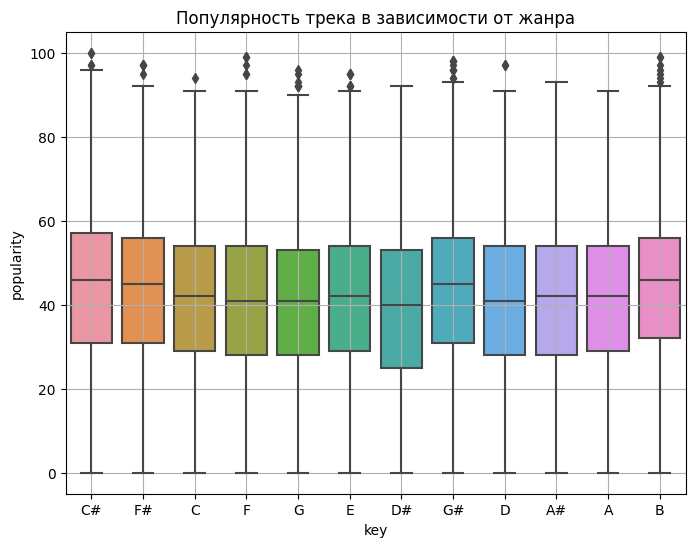

In [ ]:
# (Опционально) Здесь вы "подтверждаете" свою гипотезу
plt.figure(figsize=(8, 6))
plt.title('Популярность трека в зависимости от жанра')
sns.boxplot(data=input_data, x='key', y='popularity')
plt.grid()
plt.show()

Судя по ящику с усами медиана популярности трека несильно отличается от ключа трека. Трек с любым ключом может войти в ТОП-100 Spotify. Есть вероятность, что треки с ключами `D#`, `D`, `A`, `A#` будут чуть выше в ТОПе, но это утверждение на фоне статистической погрешности (с учетом того, что мало выбросов).

## Предобработка перед построением модели

In [ ]:
# удалим ненужные для будущей модели поля - только ID трека
input_data.drop(['track_id'], axis=1, inplace=True)

# продолжительность трека следует перевести в минуты (для будущего скалирования)
input_data['duration_min'] = input_data['duration_ms'] / (1000 * 60)
input_data.drop('duration_ms', axis=1, inplace=True)

# для модели логистической регрессии преобразуем данные через get_dummies
dummies_input_data = input_data.drop(['artist_name', 'track_name', 'genre', 'key', 'mode', 'time_signature'], axis=1)
dummies_input_data = pd.concat([dummies_input_data, pd.get_dummies(input_data[['genre', 'key', 'mode', 'time_signature']], drop_first=True)], axis=1)

# метку популярности следует преобразовать в только в несколько значений, чтобы их было проще предсказывать с учетом минимизации дисбаланса классов (заранее)
dummies_input_data.loc[dummies_input_data['popularity'].between(0, 30), 'popularity'] = 0
dummies_input_data.loc[dummies_input_data['popularity'].between(31, 50), 'popularity'] = 1
dummies_input_data.loc[dummies_input_data['popularity'].between(51, 100), 'popularity'] = 2

# численные поля
NUMBER_COLUMNS = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
                  'valence', 'artists_count', 'track_name_length', 'duration_min']

# категориальные поля
CAT_COLUMNS = [i_col for i_col in dummies_input_data.columns if i_col not in NUMBER_COLUMNS]

# остальные колонки приводим к текстовому формату
dummies_input_data[CAT_COLUMNS] = dummies_input_data[CAT_COLUMNS].astype('str')
dummies_input_data

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,time_signature_3/4,time_signature_4/4,time_signature_5/4
0,0,0.61100,0.389,0.910,0.000000,0.3460,-1.828,0.0525,166.969,0.814,...,0,0,0,0,0,0,0,0,1,0
1,0,0.24600,0.590,0.737,0.000000,0.1510,-5.559,0.0868,174.003,0.816,...,0,0,0,1,0,0,1,0,1,0
2,0,0.95200,0.663,0.131,0.000000,0.1030,-13.879,0.0362,99.488,0.368,...,0,0,0,0,0,0,1,0,0,1
3,0,0.70300,0.240,0.326,0.000000,0.0985,-12.178,0.0395,171.758,0.227,...,0,0,0,0,0,0,0,0,1,0
4,0,0.95000,0.331,0.225,0.123000,0.2020,-21.150,0.0456,140.576,0.390,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,1,0.00384,0.687,0.714,0.544000,0.0845,-10.626,0.0316,115.542,0.962,...,0,0,0,0,0,0,0,0,1,0
232721,1,0.03290,0.785,0.683,0.000880,0.2370,-6.944,0.0337,113.830,0.969,...,0,1,0,0,0,0,1,0,1,0
232722,1,0.90100,0.517,0.419,0.000000,0.0945,-8.282,0.1480,84.135,0.813,...,0,0,0,0,0,0,0,0,1,0
232723,1,0.26200,0.745,0.704,0.000000,0.3330,-7.137,0.1460,100.031,0.489,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# проверка того, что нет выраженного дисбаланса классов
dummies_input_data['popularity'].value_counts()

1    88926
2    79599
0    64192
Name: popularity, dtype: int64

# 2. Модель (5 баллов)

В этом блоке вам необходимо обучить один из алгоритмов классификации из библиотеки `sklearn` для вашего обработанного набора данных.

1. (0.5 балла) Выберите в данных признак, который будете предсказывать:

    - Если **категориальный признак**, то у неё должно быть от 2 до 10 значений (например, колонка `species` в датасете миграции птиц содержит 3 категории)
    
    - Если **количественный** признак, то его нужно **дискретизировать** (например для популярности трека в датасете `spotify` можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку.

In [ ]:
# Здесь вы выделяете колонку X (по которой будем предсказывать) и y (которым будем предсказывать)
X, y = dummies_input_data.drop('popularity', axis=1), dummies_input_data['popularity']

# надо выделить тренировочный (для обучения), валидационный (для тюнинга гиперпараметров) и тестовый датасет (для финального применения параметров)
# поскольку у нас будет использоваться GridSearchCV, то отдельная валидационная часть не требуется
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# соотношение данных в тренировочной и тестовой частях приблизительно 70/30 %
print("Процент данных в тренировочной части: {:.2f} %".format(X_train.shape[0] * 100 / X.shape[0]))
print("Процент данных в тестовой части: {:.2f} %".format(X_test.shape[0] * 100 / X.shape[0]))

# предобработка данных для формирования датасетов X (скалирование численных данных и присоединение к ним текстовых данных)
X_train_num, X_train_obj = X_train.select_dtypes('number'), X_train.select_dtypes('object').astype('int')
X_test_num, X_test_obj = X_test.select_dtypes('number'), X_test.select_dtypes('object').astype('int')

# скалирование данных
sc = StandardScaler()
X_train_num_scaled = sc.fit_transform(X_train_num)
X_test_num_scaled = sc.transform(X_test_num)

# получение конечных данных с учетом скалирования
X_train_scaled = np.hstack([X_train_num_scaled, X_train_obj.to_numpy()])
X_test_scaled = np.hstack([X_test_num_scaled, X_test_obj.to_numpy()])

Процент данных в тренировочной части: 70.00 %
Процент данных в тестовой части: 30.00 %


2.  (0.5 балла) Выделите признаки для использования в предсказании (выполните ручной отбор признаков, feature selection).
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной:

In [ ]:
# прежде чем обучать модель попробуем отобрать лучшие признаки через Feature Selection

# из 52 признаков выберем 5 самых "лучших" количественных для обучения (почему стоит 12, потому что при этом значении удобнее выбирать первые 5 количественных признаков - без get_dummies)
# признаки из get_dummies технически не являются количественными (но являются категориальными)
selector = SelectKBest(score_func=f_classif, k=12)
X_new = selector.fit_transform(X_train_scaled, y_train)

# получим названия колонок через Feature Selection
all_columns = list(X_train_num.columns) + list(X_train_obj.columns)
for_learning_features = [all_columns[i] for i in selector.get_support(indices=True)][:5]
print(f'Наши признаки для обучения: {for_learning_features}')

# те же X-признаки мы должны сделать и для 18 признаков
X_features_train_scaled = X_train_scaled[:, selector.get_support(indices=True)[:5]]
X_features_test_scaled = X_test_scaled[:, selector.get_support(indices=True)[:5]]

Наши признаки для обучения: ['acousticness', 'danceability', 'instrumentalness', 'loudness', 'track_name_length']


3. (3 балла) Выберите 3 модели классификации и обучите их корректно. Не забудьте посмотреть разные значения гиперпараметров (2-3 будет достаточно, не обязательно делать GridSearch).

## 2.1. Логистическая регрессия

In [ ]:
# напишем функцию для обучения и получения classification_report, чтобы не повторять один и тот же код
def fit_and_get_classification_report(estimator, param_grid: dict, n_splits: int, scoring: int, verbose: int, all_features: bool):

    '''
    Функция обучает модель машинного обучения при помощи GridSearchCV и строит classification_report на его основе

    Args:
    * estimator - модель машинного обучения (random_state и n_jobs пишется в нем же);
    * param_grid - сетка гиперпараметров для GridSearchCV;
    * n_splits - количество сплитов для стратифицированной выборки;
    * scoring - целевая метрика при обучения GridSearchCV;
    * verbose - параметр, отвечающий за подробность отображения процесса обучения;
    * all_features - булевый признак проведения обучения на всех признаках или только на тех, что отобраны через Feature Selecton;

    Returns:
    * best_params - лучшие гиперпараметры для данной модели машинного обучения
    '''

    # стратификация для GridSearchCV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=17)

    # создание экземпляра класса GridSearchCV и обучение
    clf = GridSearchCV(estimator = estimator, param_grid=param_grid, cv=skf, scoring=scoring, refit=True, verbose=verbose)

    if all_features == True:
        clf.fit(X_train_scaled, y_train)
        y_train_pred = clf.predict(X_train_scaled)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_features_train_scaled, y_train)
        y_train_pred = clf.predict(X_features_train_scaled)
        y_pred = clf.predict(X_features_test_scaled)

    # метрики через classification_report
    print('-'*75)
    print('КАЧЕСТВО НА TRAIN (С УЧЕТОМ ВАЛИДАЦИИ)')
    print(classification_report(y_true=y_train, y_pred=y_train_pred))
    print('-'*75)
    print('КАЧЕСТВО НА TEST')
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print('-'*75)

    # лучшие гиперпараметры
    print(f'ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ: {clf.best_params_}')

    return clf.best_params_

In [ ]:
# Здесь вы обучаете 3 модели классификации (обучаться и искать лучшие гиперпараметры будем на train, финальные предсказания делать test)

# поскольку у нас нет сильного дисбаланса классов, то в качестве целевой метрики можно использовать `accuracy` или `f1_score` (macro)
# обучим логистическую регрессию на 5 из 52 признаков
best_logreg_features_params = fit_and_get_classification_report(estimator=LogisticRegression(random_state=17, n_jobs=-1),
                                                                param_grid = {'penalty': ['l2', 'l1'], 'tol': np.logspace(-4, -2, 3), 'C': np.logspace(-1, 1, 3),
                                                                              'solver': ['lbfgs', 'saga'], 'max_iter': [200, 300]},
                                                                n_splits = 3, scoring = 'accuracy', verbose = 300, all_features = False)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3; 1/72] START C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001..
[CV 1/3; 1/72] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.494 total time=   3.5s
[CV 2/3; 1/72] START C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001..
[CV 2/3; 1/72] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.495 total time=   1.5s
[CV 3/3; 1/72] START C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001..
[CV 3/3; 1/72] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.494 total time=   1.9s
[CV 1/3; 2/72] START C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001...
[CV 1/3; 2/72] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001;, score=0.494 total time=   1.9s
[CV 2/3; 2/72] START C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001...
[CV 2/3; 2/72] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001;, score=0.495 tota

Модель не переобучена (метрики на train и test близки друг к другу), но 5 признаков явно мало для обучения модели, поэтому посмотрим на метрики на всех признаках, кроме удаленных.

In [ ]:
# обучим логистическую регрессию при лучшем гиперпараметре (который найдем вручную - очень долго обучать через GridSearchCV) на всех признаках, кроме удаленных - можно раскомменить, чтобы посмотреть
# best_logreg_params = fit_and_get_classification_report(estimator=LogisticRegression(random_state=17, n_jobs=-1),
#                                                        param_grid = {'penalty': ['l1'], 'tol': np.logspace(-4, -3, 1), 'C': np.logspace(-1, 0, 1),
#                                                                      'solver': ['saga'], 'max_iter': [200]},
#                                                        n_splits = 3, scoring = 'accuracy', verbose = 300, all_features = True)

5 количественных признаков для качественного обучения явно недостаточно для логистической регерессии (однако, в дальнейшем именно они будут использоваться для кластеризации, потому лучшие модели оставим для наглядности). Модель не переобучена, но возможно есть более хорошие estimators.

## 2.2. Случайный лес

In [ ]:
# обучим случайный лес на 5 из 52 признаков
best_rf_features_params = fit_and_get_classification_report(estimator=RandomForestClassifier(random_state=17, n_estimators=150, n_jobs=-1),
                                                            param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': np.arange(6, 9, 1),
                                                                          'min_samples_split': np.arange(3, 5, 1)},
                                                            n_splits = 3, scoring = 'accuracy', verbose = 300, all_features = False)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START criterion=gini, max_depth=6, min_samples_split=3...........
[CV 1/3; 1/18] END criterion=gini, max_depth=6, min_samples_split=3;, score=0.512 total time=  13.9s
[CV 2/3; 1/18] START criterion=gini, max_depth=6, min_samples_split=3...........
[CV 2/3; 1/18] END criterion=gini, max_depth=6, min_samples_split=3;, score=0.515 total time=  13.9s
[CV 3/3; 1/18] START criterion=gini, max_depth=6, min_samples_split=3...........
[CV 3/3; 1/18] END criterion=gini, max_depth=6, min_samples_split=3;, score=0.515 total time=  14.0s
[CV 1/3; 2/18] START criterion=gini, max_depth=6, min_samples_split=4...........
[CV 1/3; 2/18] END criterion=gini, max_depth=6, min_samples_split=4;, score=0.512 total time=  14.0s
[CV 2/3; 2/18] START criterion=gini, max_depth=6, min_samples_split=4...........
[CV 2/3; 2/18] END criterion=gini, max_depth=6, min_samples_split=4;, score=0.515 total time=  13.9s
[CV 3/3; 2/18] START criterio

Метрики случайного леса немного лучше, чем у логистической регресии, но выводы те же: 5 признаков недостаточно для качественного обучения модели.

In [ ]:
# обучим случайный лес при лучшем гиперпараметре (который найдем вручную - очень долго обучать через GridSearchCV) на всех признаках, кроме удаленных  - можно раскомменить, чтобы посмотреть
# best_rf_params = fit_and_get_classification_report(estimator=RandomForestClassifier(random_state=17, n_estimators=150, n_jobs=-1),
#                                                    param_grid = {'criterion': ['gini'], 'max_depth': np.arange(10, 11, 1),
#                                                                  'min_samples_split': np.arange(2, 3, 1)},
#                                                    n_splits = 3, scoring = 'accuracy', verbose = 300, all_features = True)

5 количественных признаков для качественного обучения явно недостаточно для случайного леса (однако, в дальнейшем именно они будут использоваться для кластеризации, потому лучшие модели оставим для наглядности). Модель не переобучена, но возможно есть более хорошие estimators.

## 2.3. CatBoost

In [ ]:
# поскольку CatBoost умеет работать с категориальными данными, то можно немного переопределить датафреймы, не используя One-Hot-Encoding

# метку популярности следует преобразовать в только в несколько значений, чтобы их было проще предсказывать с учетом минимизации дисбаланса классов (заранее)
input_data.loc[input_data['popularity'].between(0, 30), 'popularity'] = 0
input_data.loc[input_data['popularity'].between(31, 50), 'popularity'] = 1
input_data.loc[input_data['popularity'].between(51, 100), 'popularity'] = 2

# Здесь вы выделяете колонку X (по которой будем предсказывать) и y (которым будем предсказывать)
X, y = input_data.drop('popularity', axis=1), input_data['popularity']

# надо выделить тренировочный (для обучения), валидационный (для тюнинга гиперпараметров) и тестовый датасет (для финального применения параметров)
# поскольку у нас будет использоваться GridSearchCV, то отдельная валидационная часть не требуется
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# соотношение данных в тренировочной и тестовой частях приблизительно 70/30 %
print("Процент данных в тренировочной части: {:.2f} %".format(X_train.shape[0] * 100 / X.shape[0]))
print("Процент данных в тестовой части: {:.2f} %".format(X_test.shape[0] * 100 / X.shape[0]))

# предобработка данных для формирования датасетов X (скалирование численных данных и присоединение к ним текстовых данных)
X_train_num, X_train_obj = X_train.select_dtypes('number'), X_train.select_dtypes('object')
X_test_num, X_test_obj = X_test.select_dtypes('number'), X_test.select_dtypes('object')

# скалирование данных
sc = StandardScaler()
X_train_num_scaled = sc.fit_transform(X_train_num)
X_test_num_scaled = sc.transform(X_test_num)

# получение конечных данных с учетом скалирования
X_train_scaled = np.hstack([X_train_num_scaled, X_train_obj.to_numpy()])
X_test_scaled = np.hstack([X_test_num_scaled, X_test_obj.to_numpy()])

Процент данных в тренировочной части: 70.00 %
Процент данных в тестовой части: 30.00 %


In [ ]:
# получим названия колонок через Feature Selection - переопределим поля еще раз для CatBoost
all_columns = list(X_train_num.columns) + list(X_train_obj.columns)
print(f'Наши признаки для обучения: {for_learning_features}')

Наши признаки для обучения: ['acousticness', 'danceability', 'instrumentalness', 'loudness', 'track_name_length']


In [ ]:
# для CatBoost требуется дополнительная предобработка данных, поскольку надо выделять категориальные признаки
CAT_FEATURES = ['genre',	'artist_name',	'track_name',	'key',	'mode',	'time_signature']

# датафрейм со всеми признаками
for_catboost_train_df = pd.DataFrame(X_train_scaled, columns=all_columns)
for_catboost_test_df = pd.DataFrame(X_test_scaled, columns=all_columns)
for_catboost_train_df[CAT_FEATURES] = for_catboost_train_df[CAT_FEATURES].astype('str')
for_catboost_test_df[CAT_FEATURES] = for_catboost_test_df[CAT_FEATURES].astype('str')

# датафрейм только с признаками из Feature Selection
for_catboost_features_train_df = pd.DataFrame(X_features_train_scaled, columns=for_learning_features)
for_catboost_features_test_df = pd.DataFrame(X_features_test_scaled, columns=for_learning_features)

In [ ]:
# усовершенствуем функцию для обучения и получения classification_report на CatBoost, чтобы не повторять один и тот же код (из-за cat_features)
def fit_and_get_classification_report_on_catboost(estimator, param_grid: dict, n_splits: int, scoring: int, verbose: int, train_df: pd.DataFrame, test_df: pd.DataFrame):

    '''
    Функция обучает модель машинного обучения при помощи GridSearchCV и строит classification_report на его основе

    Args:
    * estimator - модель машинного обучения (random_state и n_jobs пишется в нем же);
    * param_grid - сетка гиперпараметров для GridSearchCV;
    * n_splits - количество сплитов для стратифицированной выборки;
    * scoring - целевая метрика при обучения GridSearchCV;
    * verbose - параметр, отвечающий за подробность отображения процесса обучения;
    * train_df - датасет для обучения и валидации (обучающая часть);
    * test_df - датасет для проверки метрик (тестовая часть);

    Returns:
    * best_params - лучшие гиперпараметры для данной модели машинного обучения
    '''

    # стратификация для GridSearchCV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=17)

    # создание экземпляра класса GridSearchCV и обучение
    clf = GridSearchCV(estimator = estimator, param_grid=param_grid, cv=skf, scoring=scoring, refit=True, verbose=verbose)
    clf.fit(train_df, y_train, eval_set=(test_df, y_test))
    y_train_pred = clf.predict(train_df)
    y_pred = clf.predict(test_df)

    # метрики через classification_report
    print('-'*75)
    print('КАЧЕСТВО НА TRAIN (С УЧЕТОМ ВАЛИДАЦИИ)')
    print(classification_report(y_true=y_train, y_pred=y_train_pred))
    print('-'*75)
    print('КАЧЕСТВО НА TEST')
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print('-'*75)

    # лучшие гиперпараметры
    print(f'ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ: {clf.best_params_}')

    return clf.best_params_

In [ ]:
# обучим CatBoost на 5 из 52 признаков
best_features_cb_params = fit_and_get_classification_report_on_catboost(estimator=CatBoostClassifier(random_seed=17, learning_rate=0.2),
                                                                        param_grid = {'iterations': [30, 50, 100], 'max_depth': np.arange(3, 6, 1),
                                                                                      'l2_leaf_reg': np.linspace(2, 5, 3)},
                                                                        n_splits = 3, scoring = 'accuracy', verbose = 300, train_df = for_catboost_features_train_df,
                                                                        test_df = for_catboost_features_test_df)

Выходные данные были обрезаны до нескольких последних строк (5000).
12:	learn: 0.9719237	test: 0.9731956	best: 0.9731956 (12)	total: 557ms	remaining: 729ms
13:	learn: 0.9707231	test: 0.9720049	best: 0.9720049 (13)	total: 600ms	remaining: 685ms
14:	learn: 0.9693453	test: 0.9707878	best: 0.9707878 (14)	total: 649ms	remaining: 649ms
15:	learn: 0.9679670	test: 0.9694520	best: 0.9694520 (15)	total: 720ms	remaining: 630ms
16:	learn: 0.9667366	test: 0.9682738	best: 0.9682738 (16)	total: 794ms	remaining: 607ms
17:	learn: 0.9657580	test: 0.9673569	best: 0.9673569 (17)	total: 869ms	remaining: 579ms
18:	learn: 0.9649938	test: 0.9665584	best: 0.9665584 (18)	total: 954ms	remaining: 552ms
19:	learn: 0.9641898	test: 0.9658244	best: 0.9658244 (19)	total: 1.02s	remaining: 513ms
20:	learn: 0.9636950	test: 0.9653353	best: 0.9653353 (20)	total: 1.11s	remaining: 476ms
21:	learn: 0.9633774	test: 0.9649979	best: 0.9649979 (21)	total: 1.19s	remaining: 432ms
22:	learn: 0.9628545	test: 0.9645439	best: 0.9645439

In [ ]:
# обучим CatBoost при лучшем гиперпараметре (который найдем вручную - очень долго обучать через GridSearchCV) на ВСЕХ признаках (в том числе track_name и artist_name)
best_cb_params = fit_and_get_classification_report_on_catboost(estimator=CatBoostClassifier(random_seed=17, cat_features=CAT_FEATURES, learning_rate=0.1),
                                                               param_grid = {'iterations': [25], 'max_depth': [2], 'l2_leaf_reg': [2]},
                                                               n_splits = 3, scoring = 'accuracy', verbose = 300, train_df = for_catboost_train_df,
                                                               test_df = for_catboost_test_df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START iterations=25, l2_leaf_reg=2, max_depth=2...................
0:	learn: 1.0343454	test: 1.0318426	best: 1.0318426 (0)	total: 217ms	remaining: 5.2s
1:	learn: 0.9778329	test: 0.9728179	best: 0.9728179 (1)	total: 349ms	remaining: 4.01s
2:	learn: 0.9328481	test: 0.9260208	best: 0.9260208 (2)	total: 469ms	remaining: 3.44s
3:	learn: 0.8931916	test: 0.8848449	best: 0.8848449 (3)	total: 578ms	remaining: 3.04s
4:	learn: 0.8619341	test: 0.8500992	best: 0.8500992 (4)	total: 704ms	remaining: 2.81s
5:	learn: 0.8337711	test: 0.8209377	best: 0.8209377 (5)	total: 819ms	remaining: 2.59s
6:	learn: 0.8106912	test: 0.7982774	best: 0.7982774 (6)	total: 960ms	remaining: 2.47s
7:	learn: 0.7905398	test: 0.7751844	best: 0.7751844 (7)	total: 1.07s	remaining: 2.27s
8:	learn: 0.7714284	test: 0.7554282	best: 0.7554282 (8)	total: 1.19s	remaining: 2.11s
9:	learn: 0.7544125	test: 0.7388222	best: 0.7388222 (9)	total: 1.29s	remaining: 1.94s
1

4. (1 балл) Сравните качество предсказаний моделей с помощью метрик. Метрика должна учитывать баланс классов в датасете:

Все 3 алгоритма обучают модели примерно в одинаковом качестве (как на 5 количественных признаках, так и на всех - `CatBoost` специально проверялся на всех признаках, поскольку его метрики на количественных признаках наивысшее + тяжелее переобучить estimator + удобнее всего обучать категориальные признаки, не используя One-Hot-Encoding или Label-Encoding). Логистическая регрессия и случайный лес также показывает неплохие метрики (а под ними, напомню, мы рассматриваем `F1-score` и `accuracy`), но для качественного обучения придется вводить новые признаки путем One-Hot-Encoding, что сильно увеличит хранение исходной таблицы в памяти.

Как хотелось бы улучшить метрики: 1) ввести язык песни и исполнителя - нет доступа к Spotify из-за санкций, 2) отдельно проанализировать текст песен на TF-IDF

# 3. Визуальное представление (5 баллов)

### Внимание: на этапе обучения кластеризации из-за большого количества точек файл "падает" при недостатке оперативной памяти. Потому для межкластерного и внутрикластерного расстояния можно брать оценочные величины через сэмпилрование.

Примените алгоритмы уменьшения размерности к данным из первого раздела, объясните полученные результаты.

1. (1 балл) Спроецируйте тренировочные данные в 2D пространство с помощью рассмотренных на лекциях алгоритмов снижения размерности.

In [ ]:
# Здесь вы обучаете модели понижения размерности
# создадим датафрейм и будем работать с ним при помощи алгоритма PCA (на 5 количественных признаках)
# это проще всего сделать на готовых датафреймах из CatBoost

pca = PCA(n_components=2)
pca_features_dots = pca.fit_transform(for_catboost_features_train_df)

2. (0.5 балла) Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта.

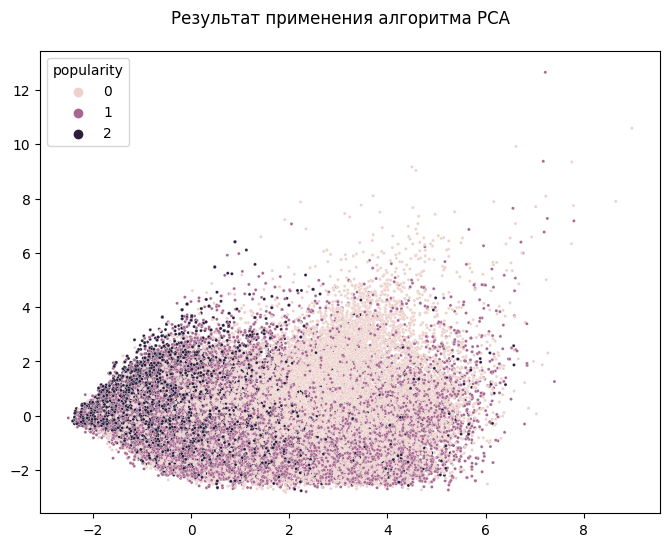

In [ ]:
# Здесь вы визуализируете с помощью моделей понижения размерности тренировочные данные
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.suptitle('Результат применения алгоритма PCA', y=0.95)
sns.scatterplot(data=pca_features_dots, x=pca_features_dots[:, 0], y=pca_features_dots[:, 1], hue=y_train, s=5, ax=ax)
plt.show()

3. (1 балл) Примените два алгоритма кластеризации к исходным (неспроецированным) данным. Расчитайте средние внутрикластерное и межкластерное расстояния.

In [ ]:
def calculate_distances(data, labels):

    '''
    Функция вычисляет средние внутрикластерное и межкластерное расстояние

    Args:
    * data - данные, на которых определяются расстояния;
    * labels - метки алгоритма кластеризации;

    Returns:
    * avg_intra_cluster_distance - среднее внутрикластерное расстояние;
    * avg_inter_cluster_distance - межкластерное расстояние;
    '''

    n_samples = len(data)
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)

    # вычисляем среднее внутрикластерное расстояние
    intra_cluster_distances = 0.0
    for label in unique_labels:
        cluster_points = data[labels == label]
        if len(cluster_points) > 1:
            dist = pairwise_distances(cluster_points, metric='euclidean')
            avg_intra_dist = np.sum(dist) / (len(cluster_points) * (len(cluster_points) - 1))
            intra_cluster_distances += avg_intra_dist

    avg_intra_cluster_distance = intra_cluster_distances / num_clusters

    # вычисляем межкластерное расстояние
    inter_cluster_distances = pairwise_distances(data, metric='euclidean')
    mask = np.ones(inter_cluster_distances.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    inter_cluster_distances = inter_cluster_distances[mask].reshape(n_samples, -1)
    avg_inter_cluster_distance = np.mean(inter_cluster_distances)

    return avg_intra_cluster_distance, avg_inter_cluster_distance

In [ ]:
# Здесь вы обучаете модели кластеризации

# в случае KMeans проблем нет - алгоритм спокойно обучается
kmeans_features = KMeans(n_clusters=3, random_state=17, n_init="auto").fit(pca_features_dots)
total_kmeans_df = pd.DataFrame(for_catboost_features_train_df)
total_kmeans_df['kmeans_label'] = kmeans_features.labels_

# выделим сэпмлы и несколько раз обучим алгоритмы AgglomerativeClustering по 15000 строк (алгоритм "падает" при большом количестве точек) - да не совсем, корректно, но можно оценить расстояния и графики кусочно
BATCH_SIZE = 15000
EPOCHS_COUNT = for_catboost_features_train_df.shape[0] // BATCH_SIZE + 1

total_agg_clustering_df = pd.DataFrame()

# вычисления расстояний
for epoch in range(EPOCHS_COUNT):
    print(f'Итерация {epoch+1}')
    for_agg_clustering_features_cluster_train_df = for_catboost_features_train_df.iloc[epoch*BATCH_SIZE:(epoch+1)*BATCH_SIZE]
    agg_clustering_features = AgglomerativeClustering(n_clusters=3).fit(for_agg_clustering_features_cluster_train_df)
    for_agg_clustering_cluster_labels = agg_clustering_features.labels_
    print(f'Среднее внутрикластерное расстояние AgglomerativeClustering: {calculate_distances(for_agg_clustering_features_cluster_train_df, for_agg_clustering_cluster_labels)[0]}')
    print(f'Межкластерное расстояние AgglomerativeClustering: {calculate_distances(for_agg_clustering_features_cluster_train_df, for_agg_clustering_cluster_labels)[1]}')
    print()
    # в цикле добавим эти же метрики для KMeans
    print(f"""Среднее внутрикластерное расстояние KMeans: {calculate_distances(total_kmeans_df.iloc[:, :-1].iloc[epoch*BATCH_SIZE:(epoch+1)*BATCH_SIZE],
                                                                               total_kmeans_df['kmeans_label'].iloc[epoch*BATCH_SIZE:(epoch+1)*BATCH_SIZE])[0]}""")
    print(f"""Межкластерное расстояние KMeans: {calculate_distances(total_kmeans_df.iloc[:, :-1].iloc[epoch*BATCH_SIZE:(epoch+1)*BATCH_SIZE],
                                                                    total_kmeans_df['kmeans_label'].iloc[epoch*BATCH_SIZE:(epoch+1)*BATCH_SIZE])[1]}""")
    print('-'*75)


    # создадим датафрейм для Agglomerative Clustering - удобно будет строить графики
    for_agg_clustering_features_cluster_train_df['agg_clust_label'] = for_agg_clustering_cluster_labels
    total_agg_clustering_df = pd.concat([total_agg_clustering_df, for_agg_clustering_features_cluster_train_df])

Итерация 1
Среднее внутрикластерное расстояние AgglomerativeClustering: 2.3912921728070526
Межкластерное расстояние AgglomerativeClustering: 3.039835953397084

Среднее внутрикластерное расстояние KMeans: 2.4176298967534486
Межкластерное расстояние KMeans: 2.7757655073404455
---------------------------------------------------------------------------
Итерация 2
Среднее внутрикластерное расстояние AgglomerativeClustering: 2.397379798303391
Межкластерное расстояние AgglomerativeClustering: 3.062297631106423

Среднее внутрикластерное расстояние KMeans: 2.3947914995692177
Межкластерное расстояние KMeans: 2.802803104202448
---------------------------------------------------------------------------
Итерация 3
Среднее внутрикластерное расстояние AgglomerativeClustering: 2.421616706882481
Межкластерное расстояние AgglomerativeClustering: 3.0363803211389735

Среднее внутрикластерное расстояние KMeans: 2.4204344690817954
Межкластерное расстояние KMeans: 2.77342691769241
---------------------------

4. (0.5 баллов) Повторите п.2, только используя метки кластеров, получаемые с помощью обученных вами моделей кластеризации, для цвета.

Номер итерации 3


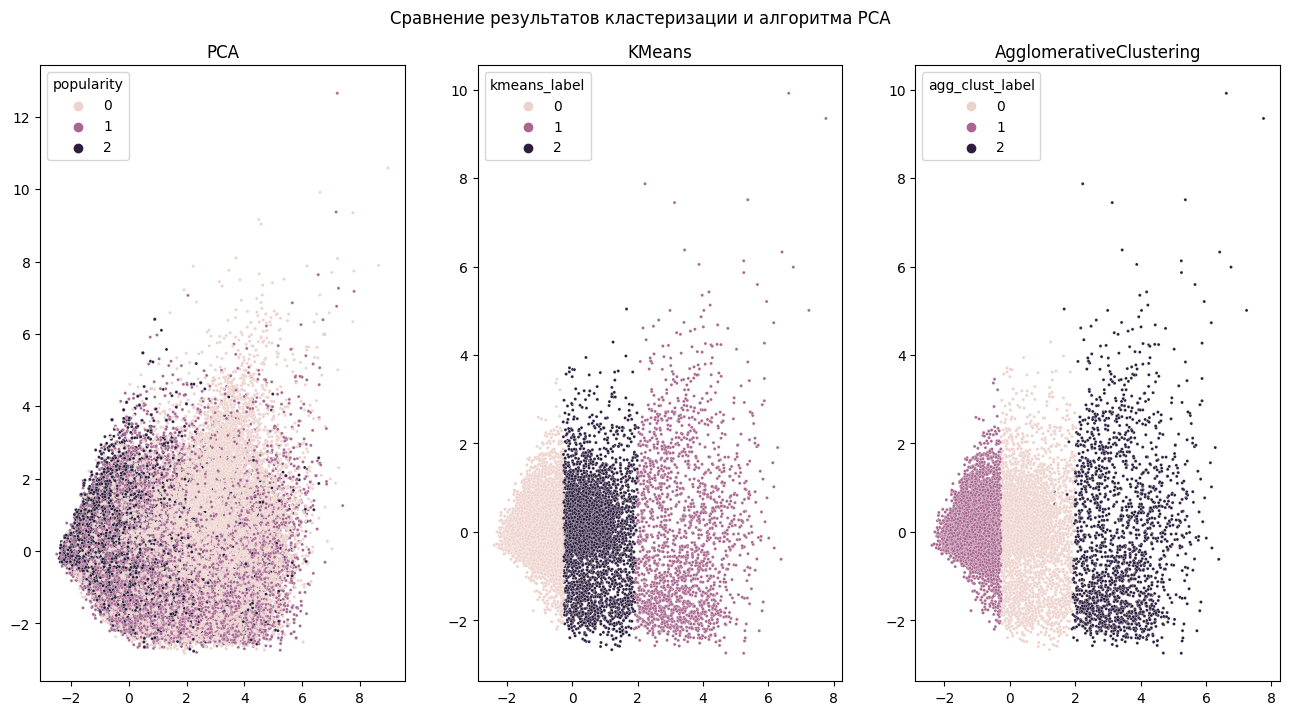

In [ ]:
# Здесь вы визуализируете с помощью моделей понижения размерности и меток кластеров тренировочные данные
# номер примера для построения графика (будем строить для 15000 точек, для выводов вполне хватит)
EXAMPLE_NUM = random.randint(0, 10)
print(f'Номер итерации {EXAMPLE_NUM+1}')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
fig.suptitle('Сравнение результатов кластеризации и алгоритма PCA', y=0.95)
# fig.suptitle('Результат применения алгоритма PCA', y=0.95)
sns.scatterplot(data=pca_features_dots, x=pca_features_dots[:, 0], y=pca_features_dots[:, 1], hue=y_train, s=5, ax=ax[0])
sns.scatterplot(x=pca_features_dots[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE][:, 0],
                y=pca_features_dots[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE][:, 1],
                hue=total_kmeans_df['kmeans_label'].iloc[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE], s=5, ax=ax[1])
sns.scatterplot(x=pca_features_dots[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE][:, 0],
                y=pca_features_dots[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE][:, 1],
                hue=total_agg_clustering_df['agg_clust_label'].iloc[EXAMPLE_NUM*BATCH_SIZE:(EXAMPLE_NUM+1)*BATCH_SIZE], s=5, ax=ax[2])
ax[0].set_title('PCA')
ax[1].set_title('KMeans')
ax[2].set_title('AgglomerativeClustering')
plt.show()

5. (2 балла) Опишите полученные вами результаты.

**Ваш анализ данных:** в ходе анализа данных было установлено несколько тезисов:

1. Точность алгоритмов кластеризации (даже при совпадении количества кластеров и меток истинных оценок - особенно, на метках 1 и 2) оставляет желать лучшего в сравнении с истинными метками. При исследовании кусочных участков датафрейма средние внутрикластерные и межкластерные расстояния двух алгоритмов - KMeans и AgglomerativeClustering близки друг к другу. Это же заметно при исследовании scatterplot, выделенные кластеры не сильно отличаются друг от друга, т.е. разница между алгоритмами минимальна.
2. К алгоритмам кластеризации следует подходить с особой осторожностью - требуют много оперативной памяти в процессе обучения; куда больше, чем, например, PCA.
3. При применении алгоритма PCA видно, что только количественных признаков недостаточно для того, чтобы достигнуть высочайшего качества выбранных метрик моделей машинного обучения. На алгоритме CatBoost (алгоритм с лучшими метриками с тем учетом, что нам не требуется One-Hot-Encoding + меньше переобучается) видно, что категориальные признаки вносят свою лепту в обучение и повышение качества, но они не указываются в алгоритме понижения размерности количественных признаков. Алгоритмы кластеризации (на нашей практике) создают линейные гиперплоскости, разделяющие точки.
4. Надо понимать, что понижение размерности != кластеризация. Первое используют в качестве выделения признаков для уменьшения времени обучения, второе является подклассом обучения без учителя. На практике видно, что метки алгоритма кластеризации НЕ МОГУТ служить качественными результатами предсказания для моделей классификации.

